In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D,Conv2D, MaxPooling1D,MaxPooling2D,MaxPooling3D, AveragePooling1D

# random seed for reproducibility
np.random.seed(12345)
plt.style.use('seaborn')


# Data Generation

We will generate `N` samples composed by 2 time series of lenght `L`, populate each of these time series with a Brownian walk, and then add a `bump` pattern consisting of half the period of a sine wave, with amplitude and sign depending on the sample label.

In [ ]:
# we want to add this pattern at various points of the gaussian time series and see if the CNN finds it

def pattern(i,z,a):
    # Z is the lenght of the "bump" due to half sin oscillation
    # a is the amplitude
    return int(a*np.sin((np.pi*i)/z))

In [ ]:
N = 10000 # number of samples
L = 200 # time-points in each samples
D = 2 # number of time series

DX = 50 # std of gaussian noise
bias = 5 # bias of gaussian noise

# pattern properties
signal_to_noise = 10
Z = 12
A = signal_to_noise*DX # default is 10*DX

n_class=3


x = np.zeros((N,L,D)) # empty array with N rows of (L,D) cells (samples)
y_l = np.random.randint(0,3,N) # array of N random numbers between 0 and 2 representing the label
                             # 0 : large pattern positive
                             # 1 : pattern present positive
                             # 2 : pattern present negative

for i in range(x.shape[0]): # running through every sample
    
    # generate noisy time series
    for j in range(x.shape[1]): # running through every time point
        if j == 0:
            x[i][j] = np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # starting gaussian noise

        else:
            x[i][j] = x[i][j-1] + np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # adding gaussian noise

    # generate pattern
    # we will generate them with a little temporal offset of 3 time points
    offset = 3
    j0 = np.random.randint(0,x.shape[1]-(Z+offset)) # do not pick the random pattern starting point closer to the edge than a whole pattern
    sign = 3-2*y_l[i]

    for j in range(0,Z):
        x[i][j0+j][0] += sign*pattern(j,Z,A)
        x[i][j0+j+offset][1] += -sign*pattern(j/2,Z,A) # second pattern a bit shifted and with a different shape,opposite sign

In [ ]:
# now to reorganize the label: instead of having an array of N numbers being either 0 or 1 or 2 corresponding to the three classes
# we will have a (N,3) array with each of the N entry being a zero vector with a 1 where the corresponding class is.
y = np.zeros((N,3))

for i in range(N):
    y[i][y_l[i]] = 1

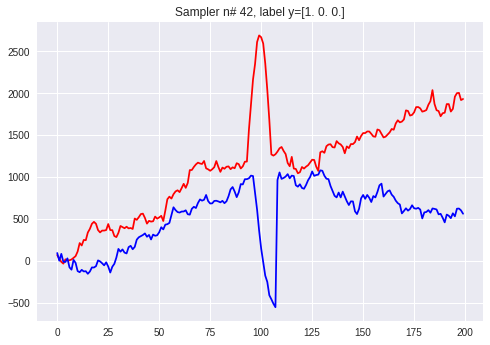

In [ ]:
i_plt = 42 # random sample
colors=['red','blue']
fig,ax = plt.subplots()
for d in range(D):
    ax.plot(x[i_plt,:,d],color=colors[d])
ax.set_title("Sampler n# {}, label y={}".format(i_plt,y[i_plt]))
plt.show()

In [ ]:
# save data
! mkdir -p DATA2_03
str0 = f'ts_L{L}_Z{Z}_A{A}_DX{DX}_bias{bias}_N{N}.dat'
fname='DATA2_03/x_'+str0
# we need to save them as .npy files as tabular data generated by savetxt cannot store 3D or higher dimensional arrays
np.save(fname,x)
fname='DATA/y_'+str0
np.save(fname,y)

# Data preparation

Now for data preparation: we will not reload the files as they have been generated in this very notebook.

First thing we will try to *detrend* the data: that is, assume a linear background trend, we will interpolate this drift and subtract it from the original time series. To do that, we will implement the convenient `scipy` 's routine as shown:

In [ ]:
from scipy.signal import detrend

# DETREND
for i in range(x.shape[0]):
    for d in range(x.shape[2]):
        x[i,:,d] = detrend(x[i,:,d])

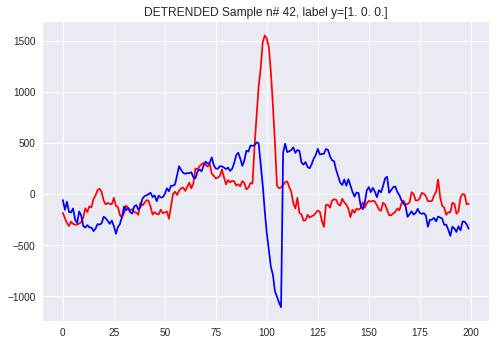

In [ ]:
i_plt = 42 # random sample
colors=['red','blue']
fig,ax = plt.subplots()
for d in range(D):
    ax.plot(x[i_plt,:,d],color=colors[d])
ax.set_title("DETRENDED Sample n# {}, label y={}".format(i_plt,y[i_plt]))
plt.show()

## Rescaling 
Since `detrend` already subtracts the offset, the dataset is already centered in 0. We will now rescale the dataset by its variance.

In [ ]:
#rescaling
x = x/np.var(x)

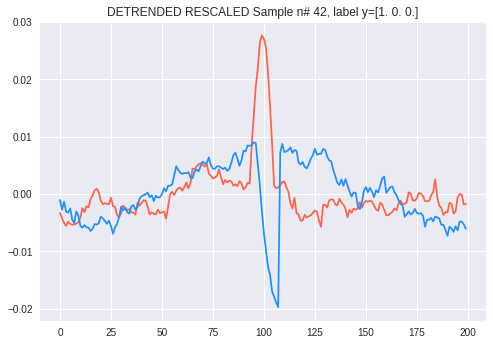

In [ ]:
i_plt = 42 # random sample
colors=['tomato','dodgerblue']
fig,ax = plt.subplots()
for d in range(D):
    ax.plot(x[i_plt,:,d],color=colors[d])
ax.set_title("DETRENDED RESCALED Sample n# {}, label y={}".format(i_plt,y[i_plt]))
plt.show()

## Train-Test Split

In [ ]:
perc_training = 0.8
n_train = int(x.shape[0]*0.8)

x_train,y_train = x[:n_train],y[:n_train]
x_val,y_val = x[n_train:],y[n_train:]


# Keras wants an additional dimension ???
# because Conv2D input is (samples,height,width,channels)


x_train = x_train.reshape(x_train.shape[0], L,D,1)
x_val =  x_val.reshape(x_val.shape[0], L,D,1)

print(x.shape)
print(x_train.shape)

(10000, 200, 2)
(8000, 200, 2, 1)


# Build model


In [ ]:
import tensorflow.random as tf_r
tf_r.set_seed(12345) # same thing with tensor module

from keras import regularizers, initializers

# lets try with ridge regularization
reg = regularizers.l2(0.0002) # l2 is ridge, l1 would be lasso
# initialize weights in some meaningful way
ini = initializers.RandomNormal(mean=1.0,stddev=0.05,seed=12345)

M = 15 # lenght of kernel: its shape will be (M,2)

In [ ]:
# define the model
model = Sequential()
#input layer
#Input shape
# 4+D tensor with shape: batch_shape + (channels, rows, cols) if data_format='channels_first' or 
# 4+D tensor with shape: batch_shape + (rows, cols, channels) if data_format='channels_last'.

model.add(Conv2D(filters=2,kernel_size=(M,2),kernel_initializer=ini,kernel_regularizer=reg,input_shape=x_train[0].shape,use_bias=False))

# output shape of this layer is (None,3,181,2), because there are 3 filters, and the input isnt padded so the width is L-M at most


# lets try to build a pooling such that we detect the maximum correlation at some point in time
# this pool 2 neighbouring points along time axis
# so that output is half the width. hopefully this will catch the offset
model.add(MaxPooling2D(pool_size=(2,1)))

model.add(Conv2D(filters=2,kernel_size=(int(M/2),1)))

model.add(Flatten())
model.add(Dense(12,activation='sigmoid')) # just a 12 neurons layer
# model.add(Dropout(0.2)) # dropout layer with rate 0.2
model.add(Dense(n_class,activation='softmax'))

print('----- MODEL SUMMARY ------')
print(model.summary())

# optimizers
#.SGD
#.RMSprop
#.Nadam

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1.,decay_steps=1000,decay_rate=0.9)
opt = tf.keras.optimizers.Adam()

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

----- MODEL SUMMARY ------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 186, 1, 2)         60        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 93, 1, 2)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 1, 2)          30        
                                                                 
 flatten (Flatten)           (None, 174)               0         
                                                                 
 dense (Dense)               (None, 12)                2100      
                                                                 
 dense_1 (Dense)             (None, 3)                 39        
                             

In [ ]:
w,=model.layers[0].get_weights()
print(w.shape) #3 filters, for 1 channel, of a 15x2 kernel
# print(b.shape) # 3 bias for each filter


(15, 2, 1, 2)


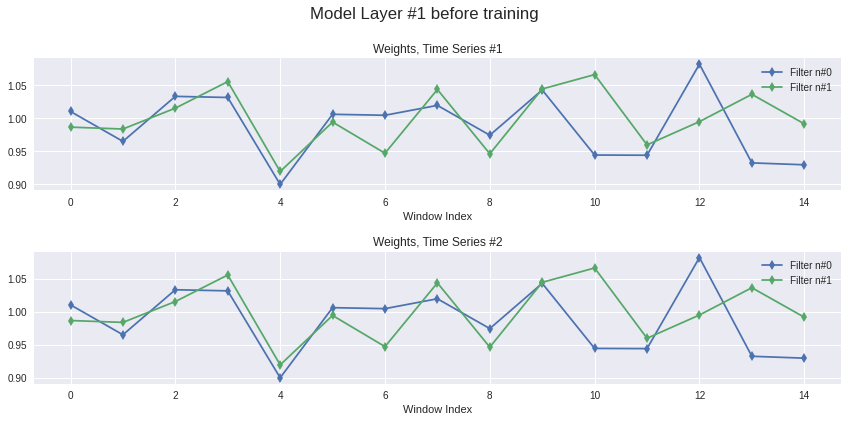

In [ ]:
fig,axs = plt.subplots(2,1,figsize=[12,6])
fig.suptitle('Model Layer #1 before training')
for i in range(w.shape[-1]): # for every filter
    axs[0].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[0].legend()
axs[0].set_title('Weights, Time Series #1')
axs[0].set_xlabel('Window Index')

for i in range(w.shape[-1]): # for every filter
    axs[1].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[1].legend()
axs[1].set_title('Weights, Time Series #2')
axs[1].set_xlabel('Window Index')


fig.tight_layout()

# Training


In [ ]:
batch_size = 1000
epochs = 250

print('------- Model  ------- \n FITTING....')
fit = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val),verbose=2,shuffle=True)

------- Model  ------- 
 FITTING....
Epoch 1/250
8/8 - 1s - loss: 1.1153 - accuracy: 0.3256 - val_loss: 1.1126 - val_accuracy: 0.3235 - 664ms/epoch - 83ms/step
Epoch 2/250
8/8 - 0s - loss: 1.1114 - accuracy: 0.3160 - val_loss: 1.1103 - val_accuracy: 0.3055 - 341ms/epoch - 43ms/step
Epoch 3/250
8/8 - 0s - loss: 1.1101 - accuracy: 0.3350 - val_loss: 1.1098 - val_accuracy: 0.3435 - 361ms/epoch - 45ms/step
Epoch 4/250
8/8 - 0s - loss: 1.1096 - accuracy: 0.3456 - val_loss: 1.1097 - val_accuracy: 0.3425 - 302ms/epoch - 38ms/step
Epoch 5/250
8/8 - 0s - loss: 1.1095 - accuracy: 0.3473 - val_loss: 1.1095 - val_accuracy: 0.3560 - 238ms/epoch - 30ms/step
Epoch 6/250
8/8 - 0s - loss: 1.1091 - accuracy: 0.3438 - val_loss: 1.1093 - val_accuracy: 0.3555 - 231ms/epoch - 29ms/step
Epoch 7/250
8/8 - 0s - loss: 1.1088 - accuracy: 0.3494 - val_loss: 1.1090 - val_accuracy: 0.3440 - 235ms/epoch - 29ms/step
Epoch 8/250
8/8 - 0s - loss: 1.1085 - accuracy: 0.3520 - val_loss: 1.1089 - val_accuracy: 0.3520 - 236

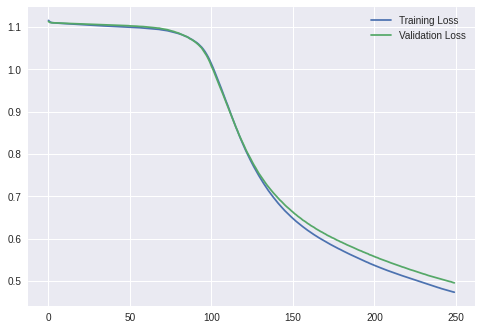

In [18]:
plt.plot(fit.history['loss'],label='Training Loss')
# fit.history.keys()
plt.plot(fit.history['val_loss'],label='Validation Loss')
plt.legend()

(15, 2, 1, 2)


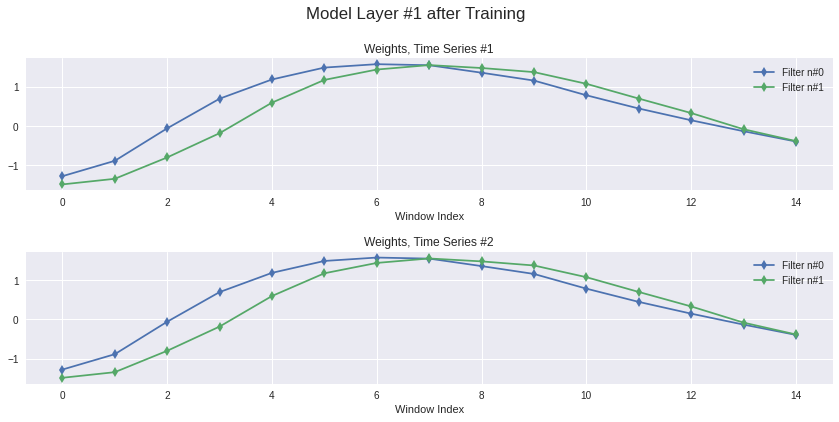

In [19]:
w=model.layers[0].get_weights()[0]
print(w.shape) # 3 filters, for 1 channel, of a 20x1 kernel

fig,axs = plt.subplots(2,1,figsize=[12,6])
fig.suptitle('Model Layer #1 after Training')
for i in range(w.shape[-1]): # for every filter
    axs[0].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[0].legend()
axs[0].set_title('Weights, Time Series #1')
axs[0].set_xlabel('Window Index')

for i in range(w.shape[-1]): # for every filter
    axs[1].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[1].legend()
axs[1].set_title('Weights, Time Series #2')
axs[1].set_xlabel('Window Index')


fig.tight_layout()

The initial weights somehow resemble half-sine bump pattern we introduced; the opposite sign due to differently labeled "bumps" is probably accounted for in the hidden layer. 
Let's test this model with different regularization parameters:

## Regularization grid search

In [19]:
lambdas = [10**(-i) for i in range(4)]
histories = {}

for la in lambdas:

    print("---- FITTING WITH LAMBDA = {} ----".format(la))


    model_cp = tf.keras.models.clone_model(model)
    reg = regularizers.L2(la)
    model_cp.layers[0].kernel_regularizer = reg
    model_cp.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

    fit_cp=model_cp.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val),verbose=1,shuffle=True)
    histories[str(la)]=fit_cp.history

---- FITTING WITH LAMBDA = 1 ----
Epoch 1/250
8/8 [==============================] - 0s 36ms/step - loss: 1.2491 - accuracy: 0.3256 - val_loss: 1.1471 - val_accuracy: 0.3235
Epoch 2/250
8/8 [==============================] - 0s 26ms/step - loss: 1.1201 - accuracy: 0.3380 - val_loss: 1.1210 - val_accuracy: 0.3365
Epoch 3/250
8/8 [==============================] - 0s 28ms/step - loss: 1.1234 - accuracy: 0.3395 - val_loss: 1.1153 - val_accuracy: 0.3365
Epoch 4/250
8/8 [==============================] - 0s 30ms/step - loss: 1.1100 - accuracy: 0.3355 - val_loss: 1.1070 - val_accuracy: 0.3575
Epoch 5/250
8/8 [==============================] - 0s 29ms/step - loss: 1.1075 - accuracy: 0.3304 - val_loss: 1.1074 - val_accuracy: 0.3225
Epoch 6/250
8/8 [==============================] - 0s 30ms/step - loss: 1.1062 - accuracy: 0.3270 - val_loss: 1.1058 - val_accuracy: 0.3335
Epoch 7/250
8/8 [==============================] - 0s 29ms/step - loss: 1.1047 - accuracy: 0.3515 - val_loss: 1.1049 - val_acc

In [1]:
for key in histories:
    plt.plot(histories[key]['loss'],label=key)

plt.legend()

NameError: name 'histories' is not defined

# Increasing signal strenght in data generation


In [21]:
# pattern properties
signal_to_noise = 100
Z = 12
A = signal_to_noise*DX # default is 10*DX

In [22]:
x = np.zeros((N,L,D)) # empty array with N rows of (L,D) cells (samples)
y_l = np.random.randint(0,3,N) # array of N random numbers between 0 and 2 representing the label
                             # 0 : large pattern positive
                             # 1 : pattern present positive
                             # 2 : pattern present negative

for i in range(x.shape[0]): # running through every sample
    
    # generate noisy time series
    for j in range(x.shape[1]): # running through every time point
        if j == 0:
            x[i][j] = np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # starting gaussian noise

        else:
            x[i][j] = x[i][j-1] + np.random.normal(loc=bias,scale=DX,size=(1,D)).astype(int) # adding gaussian noise

    # generate pattern
    # we will generate them with a little temporal offset of 3 time points
    offset = 3
    j0 = np.random.randint(0,x.shape[1]-(Z+offset)) # do not pick the random pattern starting point closer to the edge than a whole pattern
    sign = 3-2*y_l[i]

    for j in range(0,Z):
        x[i][j0+j][0] += sign*pattern(j,Z,A)
        x[i][j0+j+offset][1] += -sign*pattern(j/2,Z,A) # second pattern a bit shifted and with a different shape,opposite sign

In [23]:
# now to reorganize the label: instead of having an array of N numbers being either 0 or 1 or 2 corresponding to the three classes
# we will have a (N,3) array with each of the N entry being a zero vector with a 1 where the corresponding class is.
y = np.zeros((N,3))

for i in range(N):
    y[i][y_l[i]] = 1

In [24]:
# data preprocessing

from scipy.signal import detrend

# DETREND
for i in range(x.shape[0]):
    for d in range(x.shape[2]):
        x[i,:,d] = detrend(x[i,:,d])

# RESCALING
x = x/np.var(x)

In [25]:
#model

model_stronger = tf.keras.models.clone_model(model)
model_stronger.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

fit_stronger=model_stronger.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_val,y_val),verbose=1,shuffle=True)

Epoch 1/250
8/8 [==============================] - 1s 52ms/step - loss: 1.1330 - accuracy: 0.3265 - val_loss: 1.1096 - val_accuracy: 0.3545
Epoch 2/250
8/8 [==============================] - 0s 46ms/step - loss: 1.1120 - accuracy: 0.3380 - val_loss: 1.1122 - val_accuracy: 0.3365
Epoch 3/250
8/8 [==============================] - 0s 46ms/step - loss: 1.1077 - accuracy: 0.3444 - val_loss: 1.1074 - val_accuracy: 0.3475
Epoch 4/250
8/8 [==============================] - 0s 48ms/step - loss: 1.1064 - accuracy: 0.3505 - val_loss: 1.1067 - val_accuracy: 0.3355
Epoch 5/250
8/8 [==============================] - 0s 48ms/step - loss: 1.1046 - accuracy: 0.3601 - val_loss: 1.1057 - val_accuracy: 0.3680
Epoch 6/250
8/8 [==============================] - 0s 47ms/step - loss: 1.1035 - accuracy: 0.3658 - val_loss: 1.1051 - val_accuracy: 0.3750
Epoch 7/250
8/8 [==============================] - 0s 48ms/step - loss: 1.1025 - accuracy: 0.3716 - val_loss: 1.1042 - val_accuracy: 0.3630
Epoch 8/250
8/8 [===

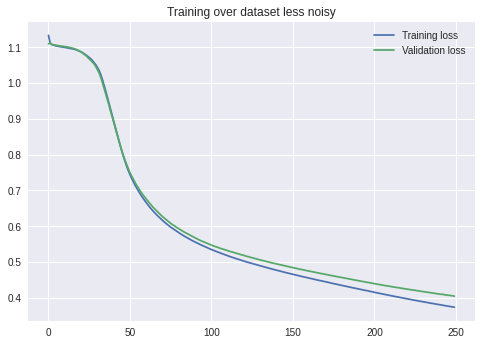

In [31]:
plt.plot(fit_stronger.history['loss'],label='Training loss')
plt.plot(fit_stronger.history['val_loss'],label='Validation loss')
plt.title("Training over dataset less noisy")
plt.legend()

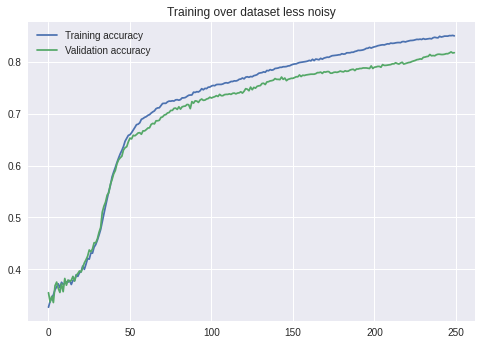

In [33]:
plt.plot(fit_stronger.history['accuracy'],label='Training accuracy')
plt.plot(fit_stronger.history['val_accuracy'],label='Validation accuracy')
plt.title("Training over dataset less noisy")
plt.legend()

(15, 2, 1, 2)


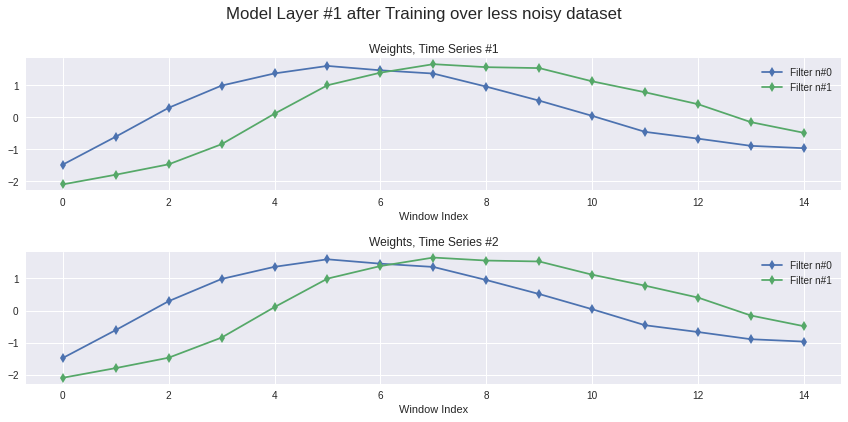

In [35]:
w=model_stronger.layers[0].get_weights()[0]
print(w.shape) # 3 filters, for 1 channel, of a 20x1 kernel

fig,axs = plt.subplots(2,1,figsize=[12,6])
fig.suptitle('Model Layer #1 after Training over less noisy dataset')
for i in range(w.shape[-1]): # for every filter
    axs[0].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[0].legend()
axs[0].set_title('Weights, Time Series #1')
axs[0].set_xlabel('Window Index')

for i in range(w.shape[-1]): # for every filter
    axs[1].plot(w[:,0,0,i],marker='d',label=f'Filter n#{i}')
axs[1].legend()
axs[1].set_title('Weights, Time Series #2')
axs[1].set_xlabel('Window Index')


fig.tight_layout()